***Bài Thực Hành 06: GAN***
1. Tìm Hiểu cách hoạt động của GAN bằng các lớp Fully-Connected, bằng cách overwrite lên hàm train_step trong Keras.Model
2. Thử tạo ra một mô hình DCGAN

In [ ]:
#Thư viện
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [ ]:
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
all_digits = all_digits.astype("float32") / 255 #đưa tấm hình về [0,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
dataset=tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

In [ ]:
#mô hình của mạng Discrimimator
discriminator=keras.Sequential()

discriminator.add(keras.Input(shape=(28,28,1)))

discriminator.add(keras.layers.Flatten())

discriminator.add(keras.layers.Dense(units=1024))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.3))

discriminator.add(keras.layers.Dense(units=512))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.3))

discriminator.add(keras.layers.Dense(units=256))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.3))

discriminator.add(keras.layers.Dense(1))

discriminator.add(keras.layers.Activation(activation="sigmoid",name="sigmoid"))  #do đây là mô hình dự đoán cho 2 nhãn nên dùng sigmoid

discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [ ]:
#mô hình của mạng Generator
latten_dim=100
generator=keras.Sequential()

generator.add(keras.Input(shape=(latten_dim,)))

generator.add(keras.layers.Dense(units=256))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

generator.add(keras.layers.Dense(units=512))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

generator.add(keras.layers.Dense(units=1024))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

generator.add(keras.layers.Dense(units=28*28))
generator.add(keras.layers.Activation(activation="sigmoid",name="sigmoid"))  #Đưa về một tấm ảnh nên dùng sigmoid để về [0,1]

generator.add(keras.layers.Reshape((28,28,1)))

generator.summary()



Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 784)             

In [ ]:
class Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Gan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(Gan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator(random_latent_vectors)

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Ở đây đánh nhãn ảnh thật là 1, ảnh giả là 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 1 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}




    

In [ ]:
#overwrite callback để lúc huấn luyện xem ảnh in ra
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #Tạo noises
        generated_images = self.model.generator(random_latent_vectors) #tạo ảnh
        generated_images *= 255 #Đưa ảnh về [0,255]
        generated_images.numpy() 
        print("epoch ",epoch)
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            display(img) #in ảnh

       
            


In [ ]:
epochs = 30 #số epochs
latent_dim =100 #số chiều cho noises
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)],verbose=0
    )

#Bài tập

1. huấn luyện mô hình DCGAN (số chiều của nhiễu là 128) với các mô hình sau đây:
    
    Generator:
    
    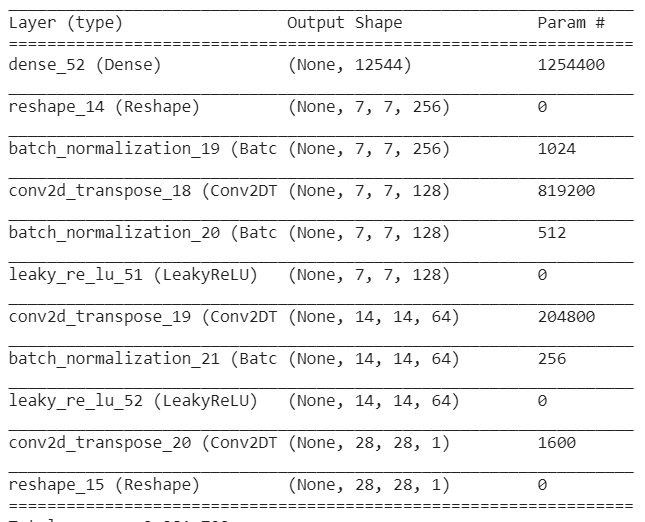

    Discriminatorr:
    
    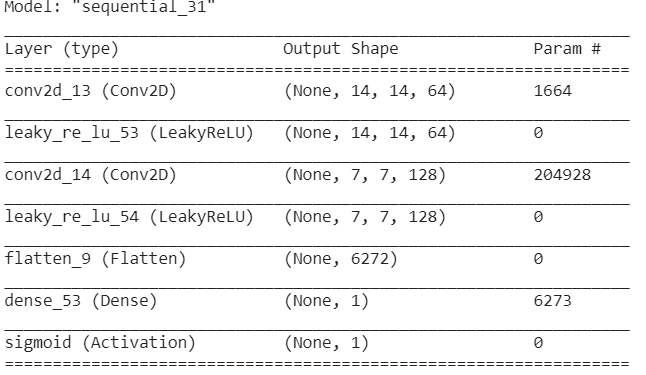


2. Từ mô hình GAN đã huấn luyện hãy viết một hàm in ra 10 hình từ noises có phân phối chuẩn